<h1 align = 'center'> CAPSTONE PROJECT - FINAL</h1>
<h3 align = 'center'>This notebook is a part of Capstone project in the course Data Scientist at Coursera</h3>

<h4>1. Introduction</h4>

Greater Helsinki is the metropolitan area surrounding Helsinki, the capital city of Finland.
The Greater Helsinki region is the largest urbanised area in the country with 1,495,271 inhabitants and is by far the most important economic, cultural, and scientific region of Finland. Five out of Finland's 15 universities and most of the headquarters of notable companies and governmental institutions are located in Greater Helsinki.

<b>Business problem</b>
As a result, there are many opportunities as well as challenges for stakeholders when coming up with starting their business in this area.
In this project scale, we will analyse and select the best location among Greater Helsinki to open a restaurant. In specify, we are planing to open a Fast Food restaurant.
Clustering technique will be used to solve the question above.

<b>Target Audience</b>
This project is particularly useful to property developers and investors looking to open or invest in
new restaurant in the Greater Helsinki. 

<h4>2. Data section</h4>

<b>To solve this data we will need the following data:</b>
<ul>
    <li>List of sub-city in Greater Helsinki. We can find the information in Wekipedia: <a>https://en.wikipedia.org/wiki/Greater_Helsinki</a>.</li>
    <li>Latitude and longtitude of each neighborhoods. We will get the geographical coordinates of the neighbourhoods using
Python Geocoder package which will give us the latitude and longitude coordinates of the
neighbourhoods.</li>
    <li>Venues data, particularly data related to restaurant. We will use Foursquare API to get the venue data for those neighbourhoods.It will provide many categories of the venue data, we are particularly interested in the
restaurant category in order to help us to solve the business problem.</li>
</ul>    

<h4>3. Data collection</h4>

In [41]:
!conda install -c conda-forge geocoder --yes
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Solving environment: ...working... 
  - anaconda::ca-certificates-2019.5.15-0, anaconda::openssl-1.1.1c-he774522_1
  - anaconda::openssl-1.1.1c-he774522_1, defaults::ca-certificates-2019.5.15-0
  - anaconda::ca-certificates-2019.5.15-0, defaults::openssl-1.1.1c-he774522_1
  - defaults::ca-certificates-2019.5.15-0, defaults::openssl-1.1.1c-he774522_1done

## Package Plan ##

  environment location: C:\Users\Loc\Anaconda3

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.

<b>Get data from wekipedia</b>

In [24]:
df = pd.read_html('https://en.wikipedia.org/wiki/Greater_Helsinki')[1]
df

,Municipality,Area,Population(2019-01-31),Population density
0,Helsinki,213.75 km²,650058,"3,041.21/km²"
1,Espoo,312.26 km²,284444,910.92/km²
2,Vantaa,238.37 km²,228678,959.34/km²
3,Kauniainen,5.88 km²,9559,"1,625.68/km²"
4,Urban area (Capital region),770.26 km²,1172739,"1,522.52/km²"
5,Hyvinkää,322.62 km²,46537,144.25/km²
6,Mäntsälä,580.84 km²,20681,35.61/km²
7,Pornainen,146.50 km²,5064,34.57/km²
8,Järvenpää,37.55 km²,43450,"1,157.12/km²"
9,Kerava,30.62 km²,36292,"1,185.24/km²"


This dataframe above already contained statistic value like urban area, commuter towns, Metropolitan area,...We just need the list of neighbohoods. So let's clean data.

In [25]:
df.drop(df.index[4], inplace = True)
df.drop(df.index[[-2,-1]], inplace = True)
df.drop(['Area','Population(2019-01-31)','Population density'],axis = 1, inplace = True)
df = df.reset_index(drop= True)
df.rename(columns ={'Municipality':'Neighborhood'},inplace = True)
df

,Neighborhood
0,Helsinki
1,Espoo
2,Vantaa
3,Kauniainen
4,Hyvinkää
5,Mäntsälä
6,Pornainen
7,Järvenpää
8,Kerava
9,Kirkkonummi


<b>Get the coordinates</b>

In [42]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Greater Helsinki, Finland'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [43]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]

In [44]:
coords

[[60.17116000000004, 24.932650000000024],
 [60.17116000000004, 24.932650000000024],
 [60.271960000000036, 24.808730000000025],
 [60.21181000000007, 24.728940000000023],
 [60.17116000000004, 24.932650000000024],
 [60.19368545380034, 24.95238136140103],
 [60.219324, 24.98638950000001],
 [60.471640000000036, 25.09075000000007],
 [60.17116000000004, 24.932650000000024],
 [60.123680000000036, 24.441520000000025],
 [60.25206532454756, 24.86735884208154],
 [60.194162028470124, 24.9390594145375],
 [60.240085415073615, 24.94780242983685],
 [60.2218575, 24.840933750000012]]

In [45]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [50]:
#merge the coordinates into dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df

,Neighborhood,Latitude,Longitude
0,Helsinki,60.171160,24.932650
1,Espoo,60.171160,24.932650
2,Vantaa,60.271960,24.808730
3,Kauniainen,60.211810,24.728940
4,Hyvinkää,60.171160,24.932650
5,Mäntsälä,60.193685,24.952381
6,Pornainen,60.219324,24.986390
7,Järvenpää,60.471640,25.090750
8,Kerava,60.171160,24.932650
9,Kirkkonummi,60.123680,24.441520


<b>Create a map of Greater Helsinki with neighborhoods</b>

In [53]:
# get the coordinates of Helsinki
address = 'Helsinki, Finland'

geolocator = Nominatim(user_agent="helsinki_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Helsinki are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Helsinki are 60.1674086, 24.9425683.


In [54]:
# create map of Helsinki area using latitude and longitude values
helsinki_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(helsinki_map)  
    
helsinki_map

<b>Use Foursquare to explore neighborhoods</b>

In [56]:
# define Foursquare Credentials and Version
CLIENT_ID = 'PCNOR5ABX2DMQPABFH0E0CWHSOWTAFLXT5MVNVWJOZ0O2EAH' # your Foursquare ID
CLIENT_SECRET = 'NMY1SJ3CQZKL2X35R0JS2U3ZXI5FFVXESEXYPYBRZ2RRVTLY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PCNOR5ABX2DMQPABFH0E0CWHSOWTAFLXT5MVNVWJOZ0O2EAH
CLIENT_SECRET:NMY1SJ3CQZKL2X35R0JS2U3ZXI5FFVXESEXYPYBRZ2RRVTLY


<b>Now, let's get the top 100 venues that are within a radius of 2000 meters.</b>

In [58]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [59]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1050, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Helsinki,60.17116,24.93265,Amos Rex,60.170643,24.936529,Art Museum
1,Helsinki,60.17116,24.93265,Taidehalli,60.172127,24.931014,Art Gallery
2,Helsinki,60.17116,24.93265,Cafe Rouge,60.168711,24.933027,Middle Eastern Restaurant
3,Helsinki,60.17116,24.93265,Farang,60.171937,24.931498,Asian Restaurant
4,Helsinki,60.17116,24.93265,Twisted Street Kitchen,60.170641,24.928203,Asian Restaurant


<b>Let's check how many venues were returned for each neighorhood</b>

In [84]:
df_barchart = venues_df.groupby(["Neighborhood"]).count()
df_barchart.drop(df_barchart.columns[[1,2,3,4,5]],axis = 1, inplace = True)
df_barchart.rename(columns = {'Latitude':'Venue'},inplace = True)
df_barchart.sort_values(by = 'Venue', inplace = True)
df_barchart

,Venue
Neighborhood,
Kirkkonummi,18
Vantaa,27
Järvenpää,50
Kauniainen,52
Tuusula,52
Pornainen,69
Vihti,88
Nurmijärvi,94
Espoo,100


Text(0.5, 1.0, 'Venues of each Neighborhood')

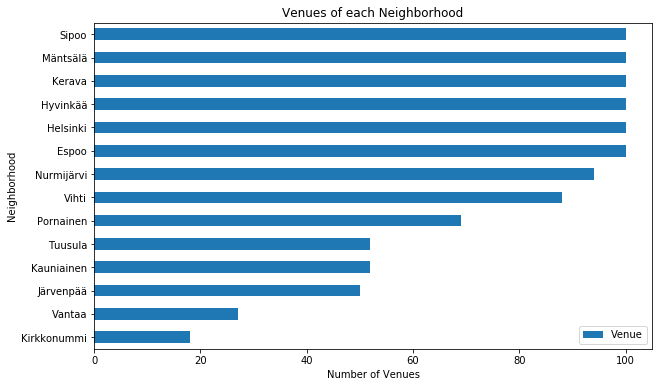

In [86]:
import matplotlib.pyplot as plt
df_barchart.plot(kind='barh', figsize=(10, 6)) # rotate the bars by 90 degrees

plt.xlabel('Number of Venues')
plt.ylabel('Neighborhood')
plt.title('Venues of each Neighborhood')


<b>Let's find out how many unique categories can be curated from all the returned venues</b>

In [87]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 193 uniques categories.


In [88]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

array(['Art Museum', 'Art Gallery', 'Middle Eastern Restaurant',
       'Asian Restaurant', 'Filipino Restaurant', 'Road',
       'Scandinavian Restaurant', 'Science Museum', 'Bookstore',
       'Health Food Store', 'Yoga Studio', 'Burrito Place', 'IT Services',
       'Coffee Shop', 'Café', 'Toy / Game Store', 'Clothing Store',
       'Record Shop', 'Bakery', 'Concert Hall', 'Indie Movie Theater',
       'Pool', 'Chinese Restaurant', 'Plaza', 'Pet Café', 'Gourmet Shop',
       'Sandwich Place', 'Beer Store', 'Indie Theater', 'Wine Bar',
       'French Restaurant', 'Restaurant', 'Furniture / Home Store',
       'Playground', 'Flower Shop', 'Organic Grocery', 'Grocery Store',
       'Japanese Restaurant', 'Bar', 'Sushi Restaurant', 'Hotel',
       'Burger Joint', 'Pizza Place', 'Mediterranean Restaurant', 'Gym',
       'Park', 'Mexican Restaurant', 'American Restaurant', 'Theater',
       'Library'], dtype=object)

In [131]:
# print out the categories that has 'restaurant'
restaurant_df = venues_df[venues_df['VenueCategory'].str.contains('Restaurant')]
restaurant_df = restaurant_df.groupby(restaurant_df['VenueCategory']).count()
restaurant_df.drop(restaurant_df.iloc[:,1:6],axis =1 , inplace = True)
restaurant_df

,Neighborhood
VenueCategory,
African Restaurant,2
American Restaurant,4
Asian Restaurant,12
Cambodian Restaurant,1
Chinese Restaurant,16
Comfort Food Restaurant,1
Doner Restaurant,2
Falafel Restaurant,1
Fast Food Restaurant,8


<b>Analize each neighborhood</b>

In [134]:
# one hot encoding
hel_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hel_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hel_onehot.columns[-1]] + list(hel_onehot.columns[:-1])
hel_onehot = hel_onehot[fixed_columns]

print(hel_onehot.shape)
hel_onehot.head()

(1050, 194)


,Neighborhoods,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Blini House,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Canal Lock,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Curling Ice,Dance Studio,Deli / Bodega,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Hill,Himalayan Restaurant,History Museum,Hockey Arena,Hockey Rink,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Lake,Library,Liquor Store,Locksmith,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Motorcycle Shop,Mountain,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Pet Café,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Recording Studio,Recreation Center,Restaurant,River,Road,Rock Club,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Sporting Goods Shop,Sports Club,Stables,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taxi Stand,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Helsinki,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Helsinki,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Helsinki,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Helsinki,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [135]:
hel_grouped = hel_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(hel_grouped.shape)
hel_grouped

(14, 194)


,Neighborhoods,ATM,African Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Blini House,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cambodian Restaurant,Canal Lock,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Curling Ice,Dance Studio,Deli / Bodega,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Electronics Store,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food Court,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Hill,Himalayan Restaurant,History Museum,Hockey Arena,Hockey Rink,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Lake,Library,Liquor Store,Locksmith,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Motorcycle Shop,Mountain,Multiplex,Museum,Music Venue,Nature Preserve,Neighborhood,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Supply Store,Pakistani Restaurant,Park,Pedestrian Plaza,Pet Café,Pet Store,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Record Shop,Recording Studio,Recreation Center,Restaurant,River,Road,Rock Club,Salon / Barbershop,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Sporting Goods Shop,Sports Club,Stables,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taxi Stand,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Track,Trail,Train Station,Tunnel,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,Espoo,0.000000,0.00,0.01,0.03,0.030000,0.000000,0.03,0.000000,0.000000,0.000000,0.01,0.000000,0.020000,0.010000,0.00,0.000000,0.010000,0.00,0.01,0.000000,0.00,0.020000,0.01,0.000000,0.00,0.01,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.010000,0.01,0.060000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.02,0.00,0.000000,0.010000,0.01,0.02,0.040000,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.000000,0.01,0.00,0.010000,0.010000,0.010000,0.000000,0.000000,0.01,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.01,0.000000,0.000000,0.01,0.01,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.000000,0.00,0.02,0.010000,0.020000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.01,0.000000,0.000000,0.020000,0.00,0.01,0.000000,0.000000,0.010000,0.000000,0.010000,0.01,0.010000,0.01,0.010000,0.01,0.000000,0.000000,0.020000,0.000000,0.01,0.000000,0.000000,0.010000,0.000000,0.060000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.02,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.

In [136]:
len(hel_grouped[hel_grouped['Fast Food Restaurant'] > 0])

5

Create a new DataFrame for Fast Food Restaurant data only

In [138]:
ffres = hel_grouped[["Neighborhoods",'Fast Food Restaurant']]
ffres

,Neighborhoods,Fast Food Restaurant
0,Espoo,0.000000
1,Helsinki,0.000000
2,Hyvinkää,0.000000
3,Järvenpää,0.040000
4,Kauniainen,0.038462
5,Kerava,0.000000
6,Kirkkonummi,0.000000
7,Mäntsälä,0.000000
8,Nurmijärvi,0.010638
9,Pornainen,0.000000


<b>Clustering Neighborhoods</b>

Run k-means to cluster the neighborhoods in area into 3 clusters.

In [140]:
# set number of clusters
kclusters = 3

ffres_clustering = ffres.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ffres_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 1, 0, 0, 0, 2, 0])

In [142]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
ffres_merged = ffres.copy()

# add clustering labels
ffres_merged["Cluster Labels"] = kmeans.labels_

In [143]:
ffres_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
ffres_merged.head()

,Neighborhood,Fast Food Restaurant,Cluster Labels
0,Espoo,0.000000,0
1,Helsinki,0.000000,0
2,Hyvinkää,0.000000,0
3,Järvenpää,0.040000,1
4,Kauniainen,0.038462,1


In [144]:
# merge dataframe to add latitude/longitude for each neighborhood
ffres_merged = ffres_merged.join(df.set_index("Neighborhood"), on="Neighborhood")

print(ffres_merged.shape)
ffres_merged.head() # check the last columns!

(14, 5)


,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
0,Espoo,0.000000,0,60.17116,24.93265
1,Helsinki,0.000000,0,60.17116,24.93265
2,Hyvinkää,0.000000,0,60.17116,24.93265
3,Järvenpää,0.040000,1,60.47164,25.09075
4,Kauniainen,0.038462,1,60.21181,24.72894


In [145]:
# sort the results by Cluster Labels
print(ffres_merged.shape)
ffres_merged.sort_values(["Cluster Labels"], inplace=True)
ffres_merged

(14, 5)


,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
0,Espoo,0.000000,0,60.171160,24.932650
1,Helsinki,0.000000,0,60.171160,24.932650
2,Hyvinkää,0.000000,0,60.171160,24.932650
5,Kerava,0.000000,0,60.171160,24.932650
6,Kirkkonummi,0.000000,0,60.123680,24.441520
7,Mäntsälä,0.000000,0,60.193685,24.952381
9,Pornainen,0.000000,0,60.219324,24.986390
10,Sipoo,0.000000,0,60.194162,24.939059
12,Vantaa,0.000000,0,60.271960,24.808730
3,Järvenpää,0.040000,1,60.471640,25.090750


<b>Finally, let's visualize the resulting clusters</b>

In [146]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ffres_merged['Latitude'], ffres_merged['Longitude'], ffres_merged['Neighborhood'], ffres_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b>Examine Clusters</b>

<b>Cluster 0</b>

In [148]:
ffres_merged.loc[ffres_merged['Cluster Labels'] == 0]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
0,Espoo,0.0,0,60.171160,24.932650
1,Helsinki,0.0,0,60.171160,24.932650
2,Hyvinkää,0.0,0,60.171160,24.932650
5,Kerava,0.0,0,60.171160,24.932650
6,Kirkkonummi,0.0,0,60.123680,24.441520
7,Mäntsälä,0.0,0,60.193685,24.952381
9,Pornainen,0.0,0,60.219324,24.986390
10,Sipoo,0.0,0,60.194162,24.939059
12,Vantaa,0.0,0,60.271960,24.808730


<b>Cluster 1</b>

In [149]:
ffres_merged.loc[ffres_merged['Cluster Labels'] == 1]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
3,Järvenpää,0.040000,1,60.471640,25.090750
4,Kauniainen,0.038462,1,60.211810,24.728940
11,Tuusula,0.038462,1,60.240085,24.947802


<b>Cluster 2</b>

In [151]:
ffres_merged.loc[ffres_merged['Cluster Labels'] == 2]

,Neighborhood,Fast Food Restaurant,Cluster Labels,Latitude,Longitude
8,Nurmijärvi,0.010638,2,60.252065,24.867359
13,Vihti,0.011364,2,60.221857,24.840934


<b>Conclusion</b>

Most of Fast food restaurants are concentrated at Cluster 1 with the highest number, and the moderate in cluster 2. The most supprised is that both of cluster 1 and 2 is not in the center of Greater Helsinki area, which has the highest population density.
This represents a great opportunity to open a fast food restaurant in cluster 1 area which contains many big neighborhoods like Espoo, Helsinki,...since there are few or not operating fast food restaurant. In contrast, startting fast food restaurant in Järvenpää, Kauniainen and Tuusula	(Cluster 1) will suffer from intense competion due to oversupply. 